# Imports

In [12]:
# data manupulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# stats
from scipy.stats import chisquare, chi2_contingency, ttest_ind
import statsmodels.api as sm
import statistics as st

# utility
import os
import string
import time
import re

import warnings
warnings.filterwarnings('ignore')

In [13]:
print("Seaborn version: ",sns.__version__)
print("Numpy version: ",np.__version__)

Seaborn version:  0.13.2
Numpy version:  1.26.4


In [14]:
# Setting color pallet
sns.set_palette(sns.color_palette())

In [15]:
DATA_DIR = os.path.join(os.getcwd(), "Dataset", "1_clean_data")
PATH = os.path.join(DATA_DIR, "clean_train_v1.csv")

In [16]:
df = pd.read_csv(PATH)

In [17]:
df.shape

(891, 12)

In [18]:
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Ticket,Cabin,Embarked,Name
0,1,0,22.0,1,0,7.2500,3,male,A/5 21171,Missing,S,"braund, mr. owen harris"
1,2,1,38.0,1,0,71.2833,1,female,PC 17599,C85,C,"cumings, mrs. john bradley (florence briggs th..."
2,3,1,26.0,0,0,7.9250,3,female,STON/O2. 3101282,Missing,S,"heikkinen, miss. laina"
3,4,1,35.0,1,0,53.1000,1,female,113803,C123,S,"futrelle, mrs. jacques heath (lily may peel)"
4,5,0,35.0,0,0,8.0500,3,male,373450,Missing,S,"allen, mr. william henry"


In [19]:
df.isna().sum()

PassengerId    0
Survived       0
Age            0
SibSp          0
Parch          0
Fare           0
Pclass         0
Sex            0
Ticket         0
Cabin          0
Embarked       0
Name           0
dtype: int64

In [20]:
TARGET_COL = ["Survived"]
ID_COL = ["PassengerId"]
TEXT_FEATURES = ["Name"]
CAT_FEATURES = [col for col in df.columns if df[col].dtype == "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]
NUM_FEATURES = [col for col in df.columns if df[col].dtype != "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]

In [21]:
print("id column: ", ID_COL)
print("target column: ", TARGET_COL)
print("categorical columns: ", CAT_FEATURES)
print("numerical columns: ", NUM_FEATURES)
print("text features: ", TEXT_FEATURES)

id column:  ['PassengerId']
target column:  ['Survived']
categorical columns:  ['Sex', 'Ticket', 'Cabin', 'Embarked']
numerical columns:  ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
text features:  ['Name']


## Correcting feature categarization : Manually

In [22]:
# TARGET_COL = ["Survived"]
# ID_COL = ["PassengerId"]
# TEXT_FEATURES = ["Name", "Name_Lower"]
CAT_FEATURES = ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']
NUM_FEATURES = ['Age', 'SibSp', 'Parch', 'Fare']

# Univariate Analysis

## Function utilities for univariate analysis

In [23]:
from scipy import stats
# tes of normality
def check_normality(data):
    """ 
    hypothesis test for normality check in continuous variable
    """
    stat, p_value = stats.shapiro(data)
    h_0 = "H0: data normally distributed"
    h_1 = "H1: data not normally distributed"
    result = ""
    if p_value < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"

    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

In [24]:
def plot_numerical_summary(df: pd.DataFrame, col: str):
    """ 
    Performs normality check on continuous variable,
    and visually show's test statistics.

    Parameters:
    df (pd.DataFrame): pandas dataframe

    col (str): column name present in dataframe

    Returns:
    None
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    df_dict=check_normality(df[col])
    df_hypo_title = "{}\n{}\np-value:{} alpha: 0.05\n Result: {}".format(df_dict["h0"],
                                                                            df_dict["h1"],
                                                                            df_dict["p_val"],
                                                                            df_dict["cc"])

    fig.suptitle(df_hypo_title)

    # plot 1 : QQ plot
    sm.qqplot(df[col], line='45', ax=axs[0][0])
    axs[0][0].set_title("Q-Q Plot")
    axs[0][0].grid(True)
    
    # plot 2 : hist plot
    sns.histplot(data=df, x=col, kde=True, ax=axs[0][1], alpha=0.25, line_kws={'linewidth': 3})
    # measure of central tendency
    mean_max = np.round(st.mean(df[col]), 2)
    median_max = np.round(st.median(df[col]), 2)
    mode_max = np.round(st.mode(df[col]), 2)
    axs[0][1].set_title(f"Mean: {mean_max} | Median: {median_max} | Mode: {mode_max}")
    axs[0][1].axvline(ymin=0,ymax=mode_max,x=df[col].mean(), color="red",label="Mean")
    axs[0][1].axvline(ymin=0,ymax=mode_max,x=df[col].median(), color="green",label="Median")
    axs[0][1].set_xlabel(col)
    axs[0][1].legend()
    axs[0][1].grid(True)

    # plot 3 : confidence interval
    # Compute mean and standard error of the mean
    mean = np.mean(df[col])
    sem = stats.sem(df[col])
    # Compute 95% confidence interval
    confidence = 0.95
    ci = stats.t.interval(confidence, len(df)-1, loc=mean, scale=sem)
    # plotting diagram
    axs[1][0].errorbar(mean, 1, xerr=[[mean-ci[0]], [ci[1]-mean]], fmt='o', capsize=10, capthick=2, ecolor='red', linestyle='none')
    axs[1][0].axvline(mean, color='gray', linestyle='--', label=f'Mean = {mean:.2f}')
    axs[1][0].set_ylim(0.5, 1.5) 
    axs[1][0].set_xlim(ci[0] - 1, ci[1] + 1) 
    # Customize labels and title
    axs[1][0].set_xlabel('Mean Value')
    axs[1][0].set_title(f'Mean: {mean:.2f} | 95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})')
    axs[1][0].legend()
    axs[1][0].grid(True)

    
    # plot 4 : box plot
    axs[1][1].boxplot(df[col], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            # meanprops=dict(color='red'),
            medianprops=dict(color='green'))
    axs[1][1].set_xlabel('Value')
    axs[1][1].set_title('Horizontal Box Plot')
    axs[1][1].grid(True)

    plt.tight_layout()
    plt.show()

In [25]:
def chisquare_test(df, col):
    """
    we compare the observed frequencies of categories within that variable 
    to the expected frequencies under a specified distribution or hypothesis
    """
    h_0="H0: observed == expected"
    h_1="H1: observed != expected"
    observed = np.array(df[col].value_counts())
    total_observed = np.sum(observed)
    expected = np.array([total_observed/df[col].nunique()] * df[col].nunique())
    # Perform chi-square goodness-of-fit test
    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

In [26]:
def plot_categorical_summary(df, col):
    """
    this function is here to plot countplot and pie chart for categories
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    df_dict=chisquare_test(df, col)
    df_hypo_title = "{}\n{}\np-value:{} alpha: 0.05\n Result: {}".format(df_dict["h0"],
                                                                        df_dict["h1"],
                                                                        df_dict["p_val"],
                                                                        df_dict["cc"])
    fig.suptitle(df_hypo_title)
    
    # Calculate subtotals per category
    subtotals = df.groupby(col, sort=False).size().reset_index(name='Subtotal')
    subtotals = subtotals.sort_values(by='Subtotal') # sorting values, but not index
    subtotals = subtotals.reset_index(drop=True) # sorting index

    # add expected horizontal line in count plot
    y = df[col].shape[0]/df[col].nunique()
    axs[0].axhline(y=y, color='red', linestyle='--', label='expected')

    # count plot: observed vs expected
    sns.countplot(data=df, x=col, ax=axs[0], order=subtotals[col], hue_order=subtotals[col])
    axs[0].legend()
    # Add subtotals as annotations
    for index, row in subtotals.iterrows():
        axs[0].text(index, row['Subtotal'] + 1, row['Subtotal'], ha='center', va='bottom', fontsize=10)
    # pie chart
    df[col].value_counts(ascending=True).plot(kind="pie", autopct="%.2f", ax=axs[1])
    plt.tight_layout()
    plt.show()

## Numerical Variables

In [27]:
NUM_FEATURES

['Age', 'SibSp', 'Parch', 'Fare']

- Age
- Fare
- SibSp
- Parch

### Age

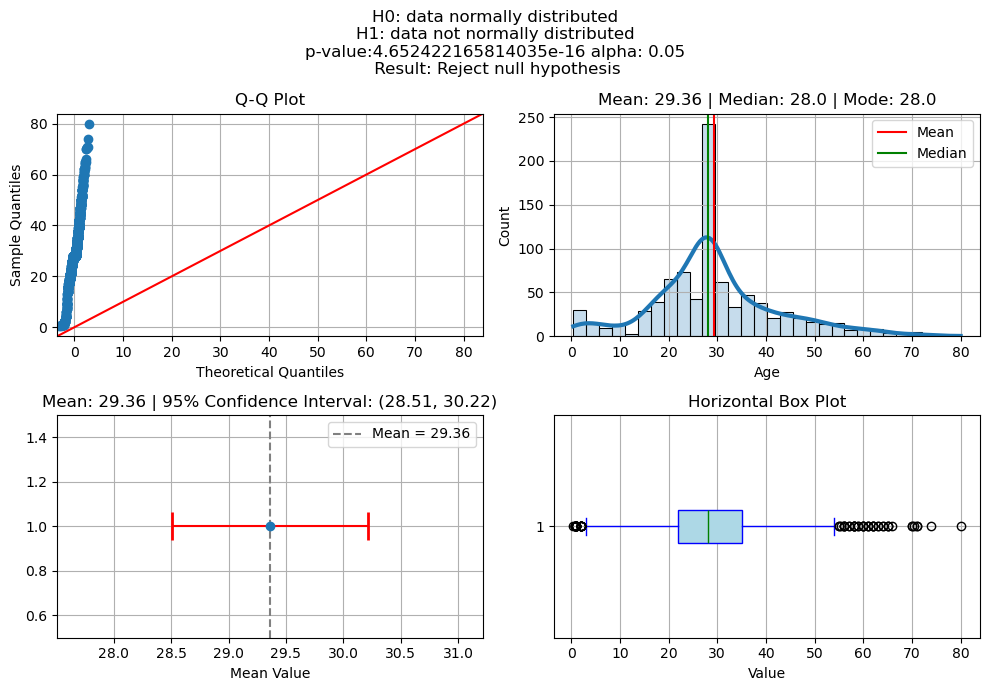

In [28]:
plot_numerical_summary(df, "Age")

### Fare

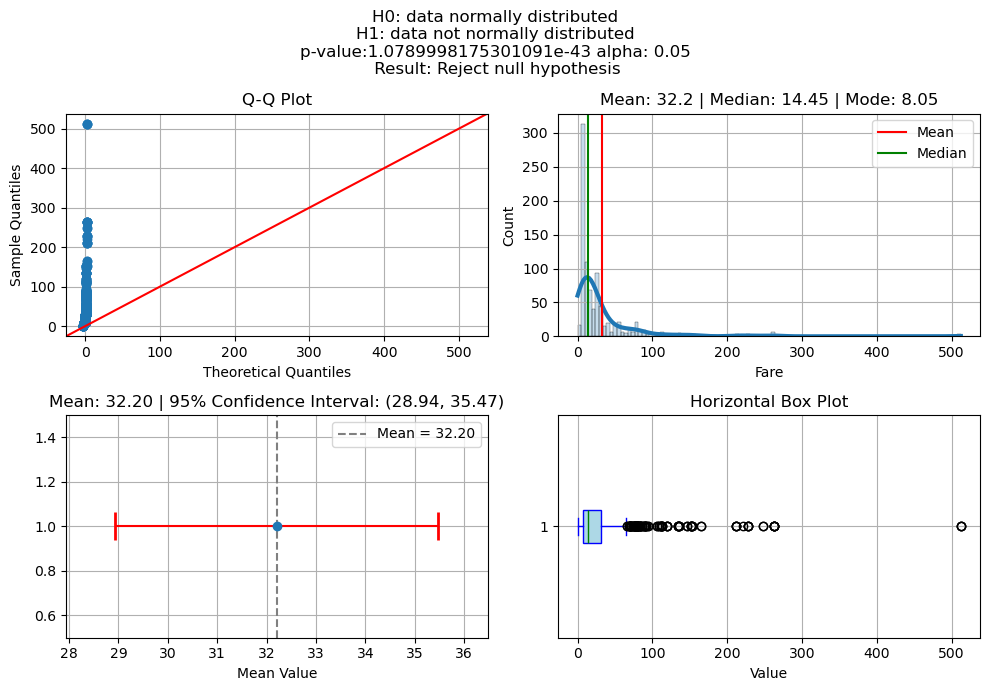

In [29]:
plot_numerical_summary(df, "Fare")

### SibSp

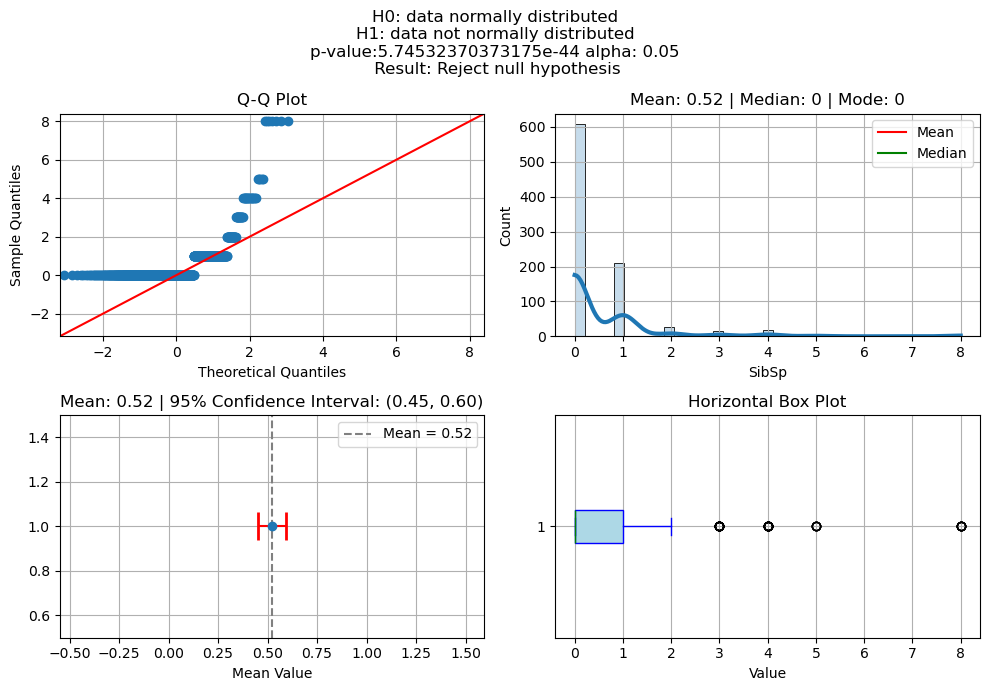

In [30]:
plot_numerical_summary(df, "SibSp")

### Parch

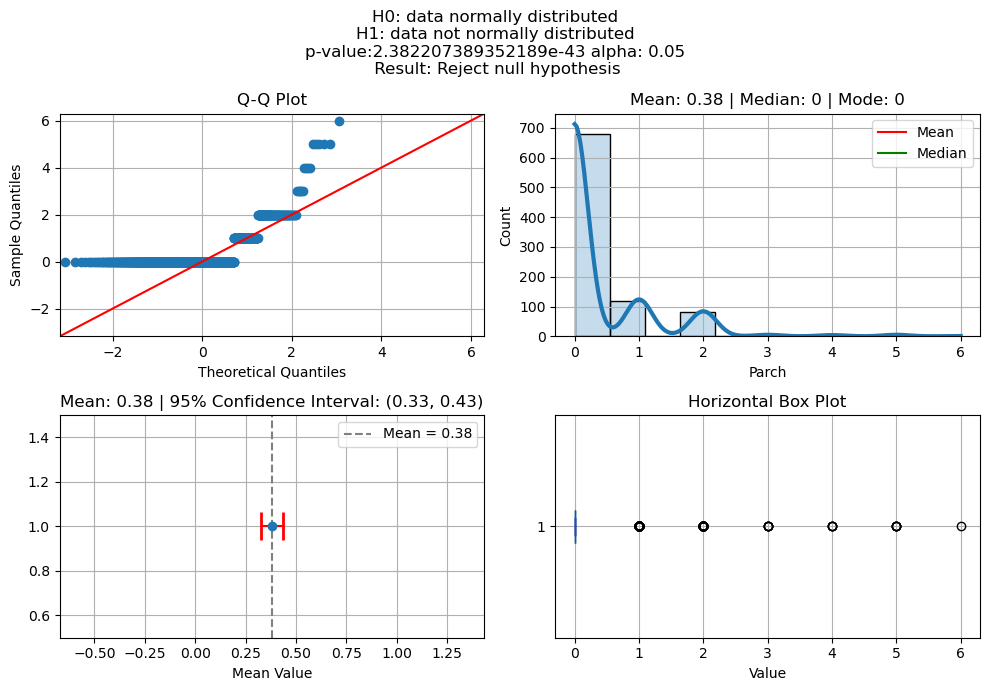

In [31]:
plot_numerical_summary(df, "Parch")

**Conclusion:**

- Both `Age` and `Fear` are not normally distributed
- Non-parametric test's are preferable for bivariate analysis
- **SibSp**, **Parch** data pusses both qualities , being a discrete in range and also ordinal categories

## Categorical Variables

- Survival
- Pclass
- SibSp
- Parch
- Sex
- Embarked
- Cabin
- Ticket

### Pclass

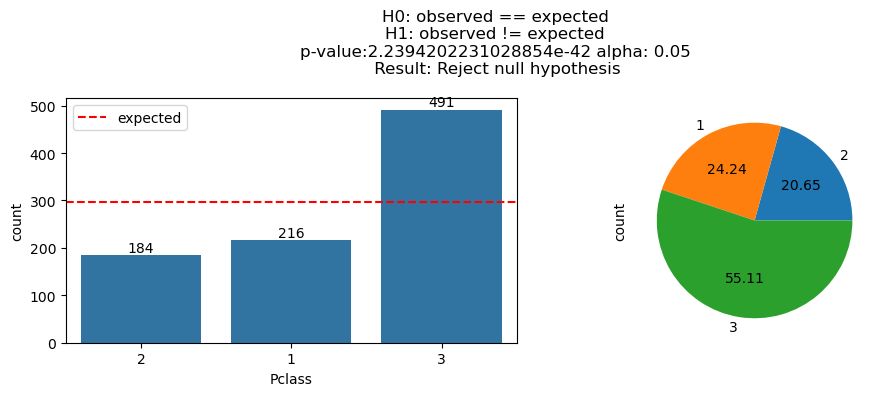

In [32]:
plot_categorical_summary(df, "Pclass")

- Diffrent classes of tickets, passenger's has bought
- 50% of passengers are from class 3
- Rest 50% distributed approx equally between class 1 and class 2

### SibSp

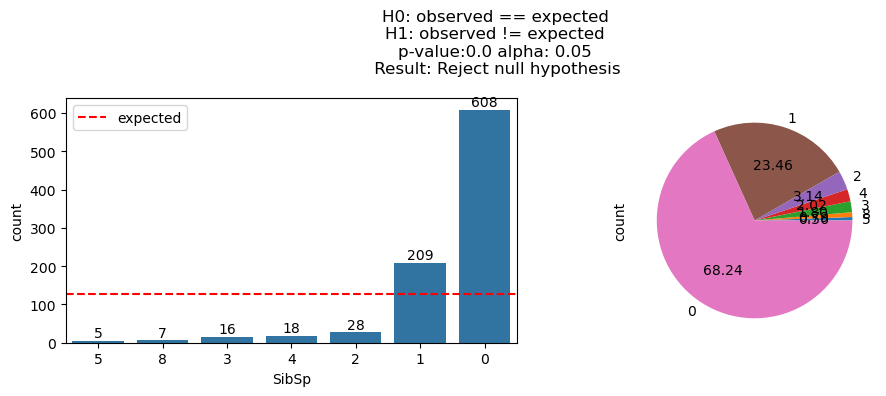

In [33]:
plot_categorical_summary(df, "SibSp")

- ~70% of passenger's don't have sibling or spouse with them
- ~ 20% of pseenger's have either of 1 spling or sopuse with them
- ~ 10% of passenger's have mone than one sibling or spouse with them

### Parch

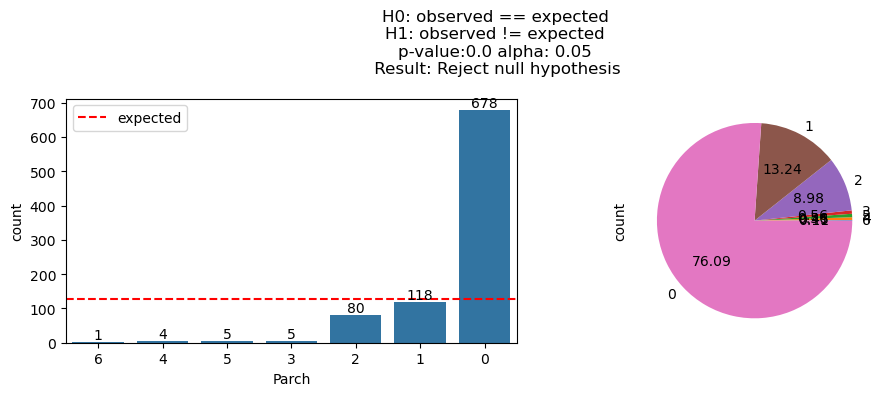

In [34]:
plot_categorical_summary(df, "Parch")

- ~75% passegngers don't have parents or children with them
- ~13% passengers have a child or a parent with them
- ~10% passengers have more than 1 parent or children with them

### Sex

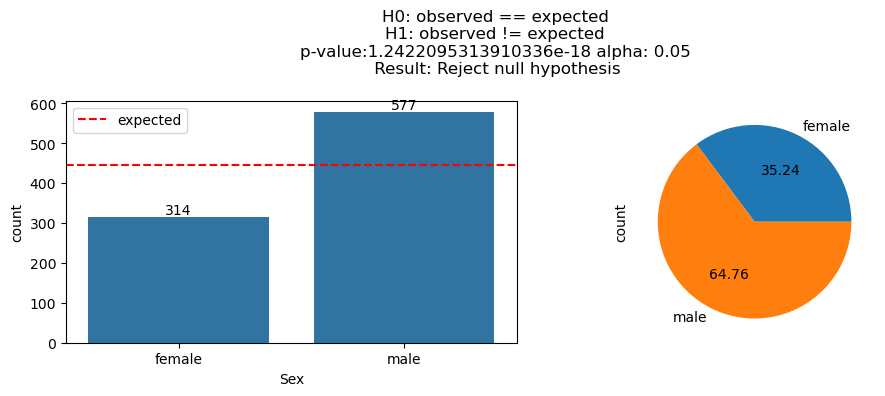

In [35]:
plot_categorical_summary(df, "Sex")

- males are ~65%
- females are ~35%

### Embarked

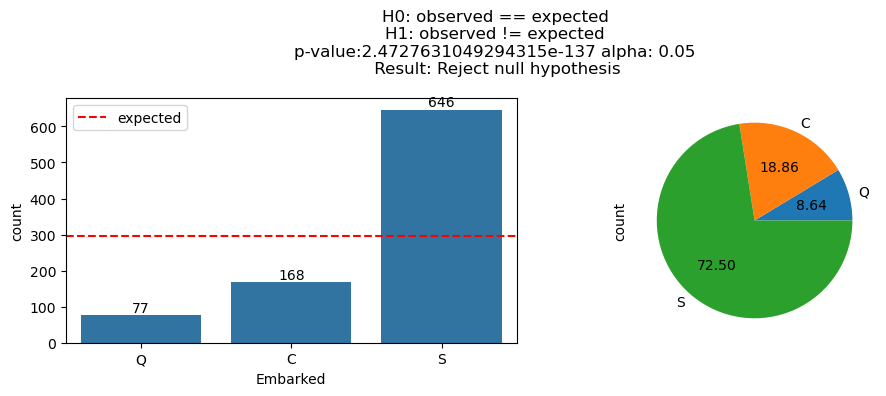

In [36]:
plot_categorical_summary(df, "Embarked")

- ~72% passengers embarked from S
- ~19% from C and ~9% from Q

### Survived

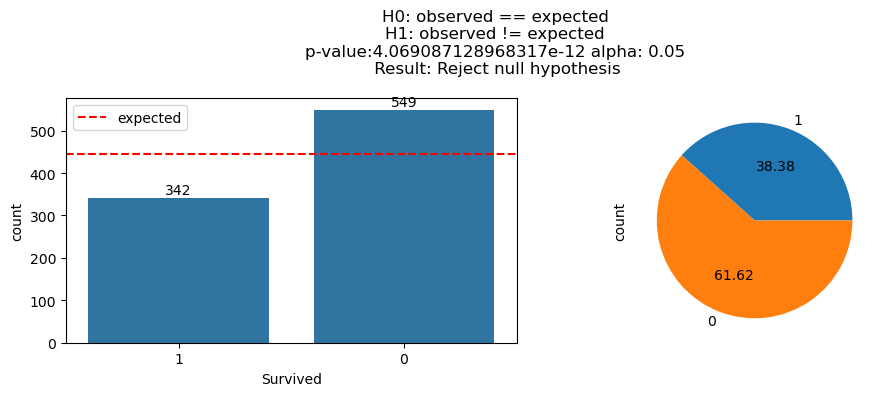

In [37]:
plot_categorical_summary(df, "Survived")

- ~62% passengers , not survived the crash
- only ~39% passengers survived the crash

### Cabin

In [39]:
df["Cabin_ticket_list"] = df["Cabin"].apply(lambda x: x.split(" ") if x!='Missing' else [])

In [40]:
df["Cabin_seat_count"] = df["Cabin_ticket_list"].apply(lambda x: len(x) if len(x) > 0 else -1)

In [41]:
df[["Cabin", "Cabin_ticket_list", "Cabin_seat_count"]]

,Cabin,Cabin_ticket_list,Cabin_seat_count
0,Missing,[],-1
1,C85,[C85],1
2,Missing,[],-1
3,C123,[C123],1
4,Missing,[],-1
...,...,...,...
886,Missing,[],-1
887,B42,[B42],1
888,Missing,[],-1
889,C148,[C148],1


In [42]:
df["Cabin_seat_count"].value_counts()

Cabin_seat_count
-1    687
 1    180
 2     16
 3      6
 4      2
Name: count, dtype: int64

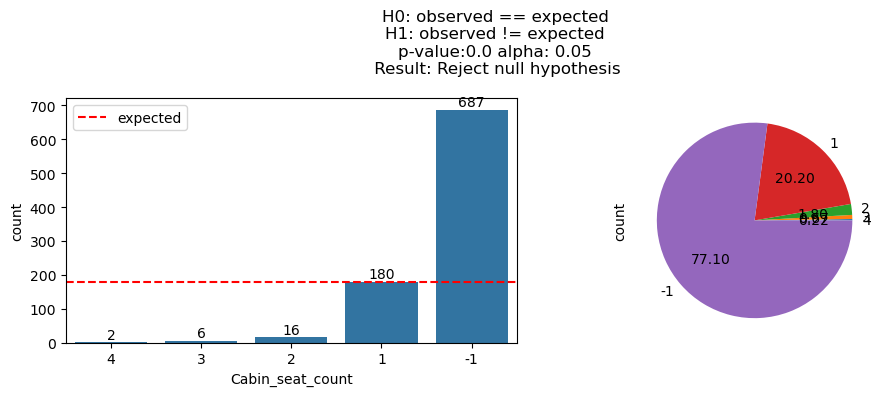

In [43]:
plot_categorical_summary(df, "Cabin_seat_count")

**connclusion:**

- ~ 77% passengers cabin is unknown
- rest are with family members

**Future Action:**

- we can use `cabin_seat_count` and `Family_member_count` = `SibSp + Parch` to create new feature to know on one ticket how many passengers on boarded 
- will check `cabin_seat_count` with `Family_member_count` and also use `Fear` to know ticket price and price distribution according to different cabin

In [44]:
df["Cabin"].apply(lambda x: x[0])

0      M
1      C
2      M
3      C
4      M
      ..
886    M
887    B
888    M
889    C
890    M
Name: Cabin, Length: 891, dtype: object

In [45]:
df["Cabin_group"] = df["Cabin"].apply(lambda x: x[0])

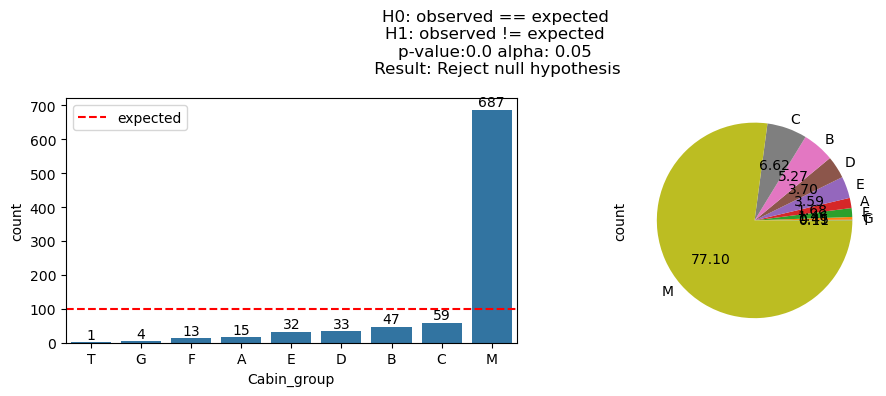

In [46]:
plot_categorical_summary(df, "Cabin_group")

**conclusion:**

- we can estimate cabin values using supervised or unsupervised approach

**Future Action:**

- passenger -> pclass -> fare -> Embarked -> Ticket = Cabin we can categorise cabins based on pclass and family member count 
- `Cabin` -> `Cabin Tag`[A, B, C, D, E, F, G, T] |  `Cabin Room Range`(numerical range)

### Ticket

In [30]:
df["Ticket"].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [31]:
df["Ticket"]#.isna().sum()

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

**conclusion:**

- so many values of different type

**Future Action:**
- while estimating `Cabin` we can use `Ticket` as well to know what range of ticket's sold under that cabin tag

# Bivariate Analysis

In [91]:
# chi squre test of independence
def chisquare_independence_test(df, x_col, y_col):
    """
    To determine if there is a significant association or relationship between two categorical variables.
    """
    h_0=f"H0: no relation btween {x_col} & {y_col}" # both are independent
    h_1=f"H1: relation btween {x_col} & {y_col}" # there is a dependency
    contingency_table = pd.crosstab(df[x_col], df[y_col])
    # Perform Chi-square test of independence
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

In [33]:
def plot_bivariate(df, x_col, y_col):
    """
    Plots countplot and pie chart for categories
    """
    plt.figure(figsize=(10, 4))
    df_dict=chisquare_independence_test(df, x_col, y_col)
    df_hypo_title = "{}\n{}\np-value:{} alpha: 0.05\n Result: {}".format(df_dict["h0"],
                                                                        df_dict["h1"],
                                                                        df_dict["p_val"],
                                                                        df_dict["cc"])
    plt.title(df_hypo_title)
    # print(type(subtotals))
    sns.countplot(x=df[x_col].astype('str'), hue=df[y_col].astype('str'))
    plt.show()

### 1. Numerical - Numerical

- Age (float) - numrical
- Fare (integer) - numrical
- SibSp (ordinal) - numerical
- Parch (ordinal) - numerical

In [64]:
# df.columns

In [65]:
NUM_NUM = ["Age_imputed_median", "Fare", "SibSp", "Parch"]

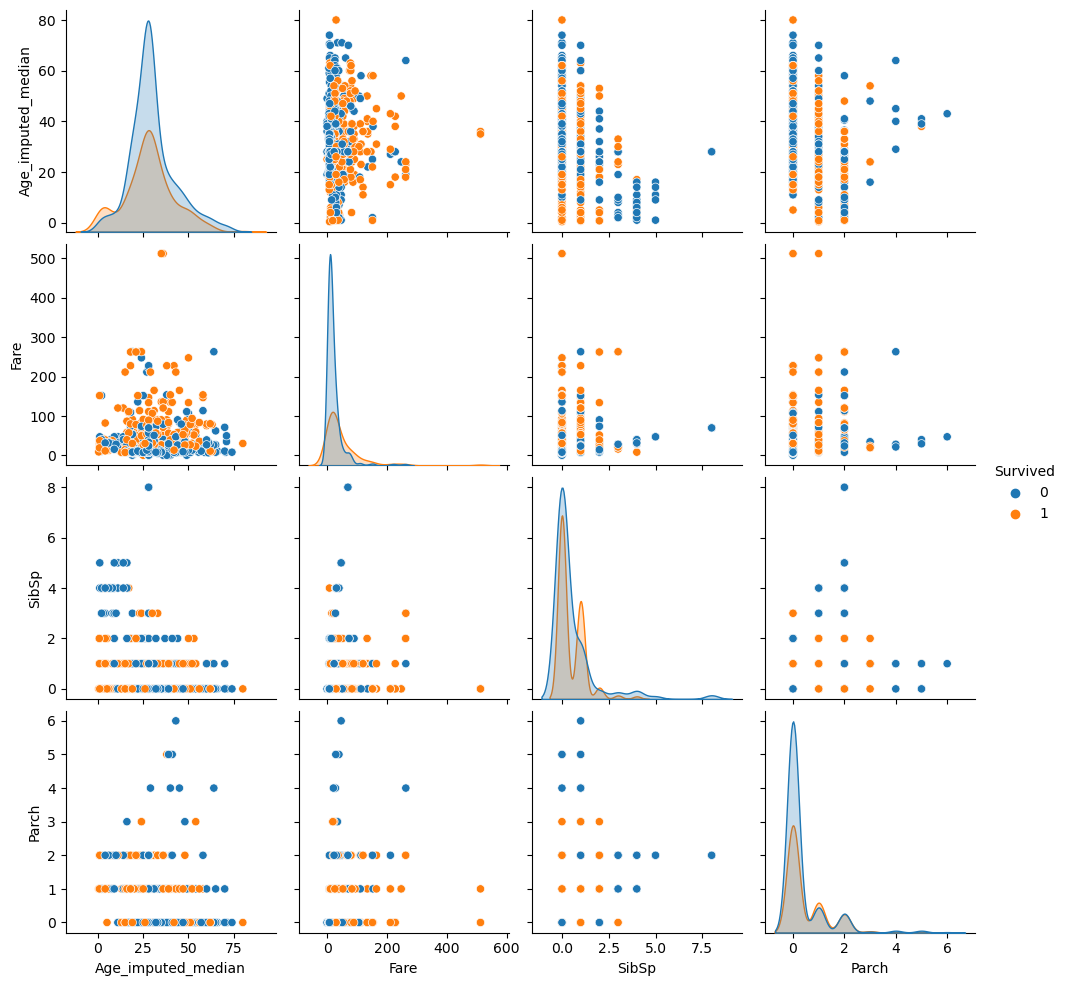

In [66]:
# sns.pairplot(data=df,vars=NUM_NUM)
sns.pairplot(data=df,vars=NUM_NUM, hue=TARGET_COL[0])

In [48]:
method : {'pearson', 'kendall', 'spearman'}

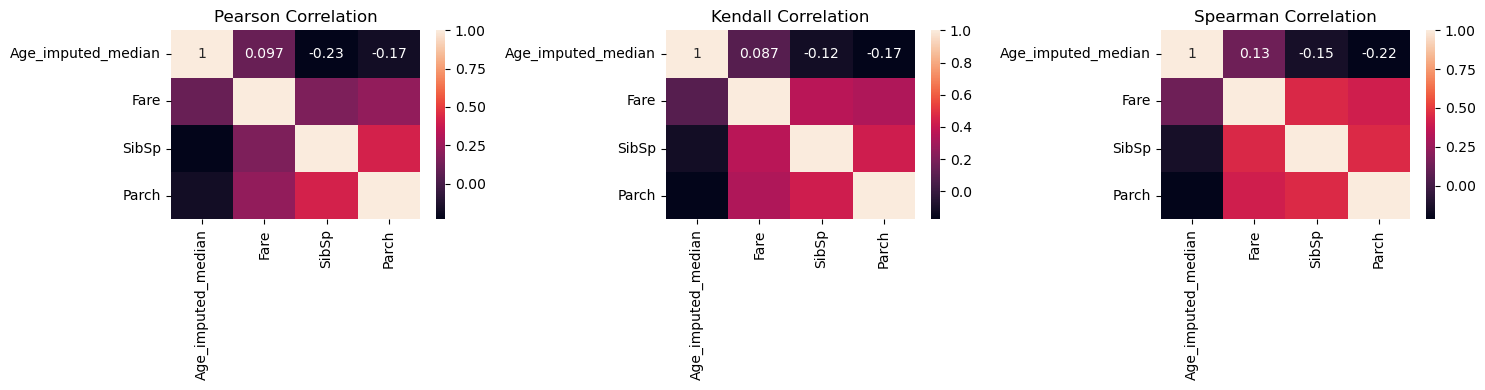

In [85]:
df_corr_person = df[NUM_NUM].corr(method='pearson') # assumption : if data had linear relation : parametric
df_corr_kendall = df[NUM_NUM].corr(method='kendall') # two categorical variables
df_corr_spearman = df[NUM_NUM].corr(method='spearman') # assumption : if data had non linear relation : non-parametric

fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.heatmap(df_corr_person, annot=True, ax=axes[0])
axes[0].set_title("Pearson Correlation")

sns.heatmap(df_corr_kendall, annot=True, ax=axes[1])
axes[1].set_title("Kendall Correlation")

sns.heatmap(df_corr_spearman, annot=True, ax=axes[2])
axes[2].set_title("Spearman Correlation")

plt.tight_layout()
plt.show()

In [86]:
# Define custom colors and boundaries
colors = ['#0D47A1', '#1976D2', '#64B5F6', '#90CAF9',  # Blue shades for positive values
          '#FFEB3B', '#FFC107', '#FF9800', '#F57C00']  # Orange shades for negative values

In [87]:
def highlight_scores(value):
    # print(value)
    if value > 0:
        if value >= 0.75: # 0.76 to 1.0
            return f'background-color: {colors[0]}; color: black'
        elif value >= 0.50: # 0.51 to 0.75 
            return f'background-color: {colors[1]}; color: black'
        elif value >= 0.25: # 0.26 to 0.50
            return f'background-color: {colors[2]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {colors[3]}; color: red'
    else:
        if  value >=-0.25 : # 0.0 to -0.25 
            return f'background-color: {colors[4]}; color: red'
        elif value >= -0.50: # -0.26 to -0.50
            return f'background-color: {colors[5]}; color: black'
        elif value >= -0.75: # -0.51 to -0.75
            return f'background-color: {colors[6]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {colors[7]}; color: black'

In [88]:
df_corr_person.style.applymap(highlight_scores, subset=NUM_NUM)

,Age_imputed_median,Fare,SibSp,Parch
Age_imputed_median,1.000000,0.096688,-0.233296,-0.172482
Fare,0.096688,1.000000,0.159651,0.216225
SibSp,-0.233296,0.159651,1.000000,0.414838
Parch,-0.172482,0.216225,0.414838,1.000000


In [89]:
df_corr_kendall.style.applymap(highlight_scores, subset=NUM_NUM)

,Age_imputed_median,Fare,SibSp,Parch
Age_imputed_median,1.000000,0.087221,-0.115427,-0.174819
Fare,0.087221,1.000000,0.358262,0.330360
SibSp,-0.115427,0.358262,1.000000,0.425241
Parch,-0.174819,0.330360,0.425241,1.000000


In [90]:
df_corr_spearman.style.applymap(highlight_scores, subset=NUM_NUM)

,Age_imputed_median,Fare,SibSp,Parch
Age_imputed_median,1.000000,0.126006,-0.145316,-0.217488
Fare,0.126006,1.000000,0.447113,0.410074
SibSp,-0.145316,0.447113,1.000000,0.450014
Parch,-0.217488,0.410074,0.450014,1.000000


Good Pairs to Proceed Further:

- correlation > 40% :
    - `Fare` & `SibSp` 
    - `Fare` & `Parch`
    - `Parch` & `SibSp`

#### 1. Fare vs Parch

Text(0.5, 1.0, 'Linear Fit')

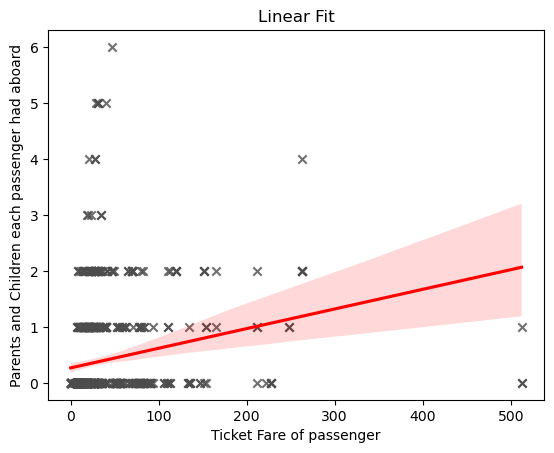

In [91]:
sns.regplot(
    data=df, x="Fare", y="Parch",
    ci=99, marker="x", color=".3", line_kws=dict(color="r"),
)
plt.xlabel("Ticket Fare of passenger")
plt.ylabel("Parents and Children each passenger had aboard")
plt.title("Linear Fit")

#### 2. SibSp vs Parch

Text(0.5, 1.0, 'Linear Fit')

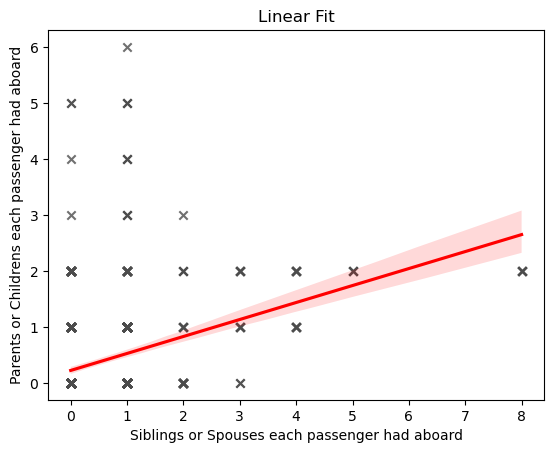

In [44]:
sns.regplot(
    data=df, x="SibSp", y="Parch",
    ci=99, marker="x", color=".3", line_kws=dict(color="r"),
)
plt.xlabel("Siblings or Spouses each passenger had aboard")
plt.ylabel("Parents or Childrens each passenger had aboard")
plt.title("Linear Fit")

#### 3. Fare vs SibSp

Text(0.5, 1.0, 'Linear Fit')

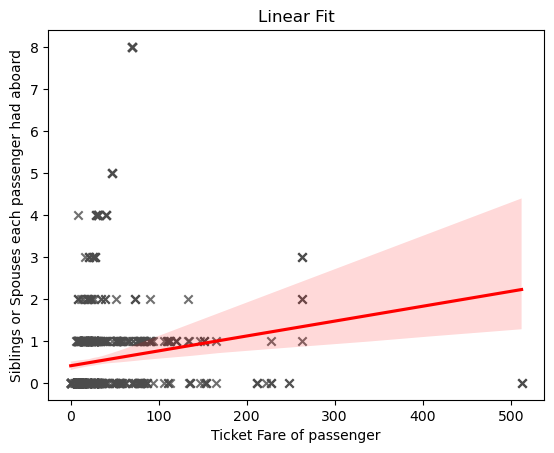

In [45]:
sns.regplot(
    data=df, x="Fare", y="SibSp",
    ci=99, marker="x", color=".3", line_kws=dict(color="r"),
)
plt.ylabel("Siblings or Spouses each passenger had aboard")
plt.xlabel("Ticket Fare of passenger")
plt.title("Linear Fit")

- From above infomation we can engineer a new features as family_members_count = Parch + SibSp  

In [92]:
df["Family_Member_Count"] = df["Parch"] + df["SibSp"]

#### 4. Fare vs Family_Member_Count

Text(0.5, 1.0, 'Linear Fit')

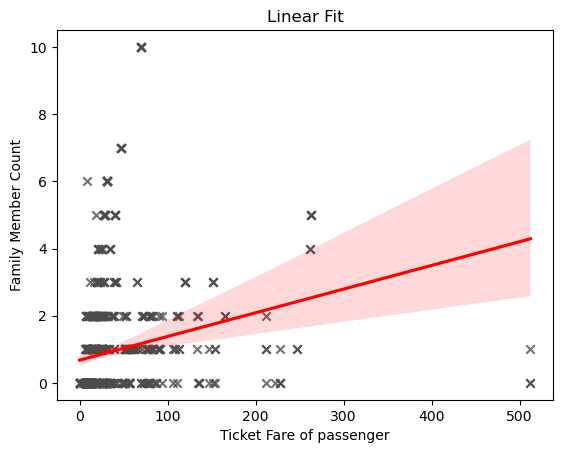

In [93]:
sns.regplot(
    data=df, x="Fare", y="Family_Member_Count",
    ci=99, marker="x", color=".3", line_kws=dict(color="r"),
)
plt.ylabel("Family Member Count")
plt.xlabel("Ticket Fare of passenger")
plt.title("Linear Fit")

In [94]:
NUM_NUM += ["Family_Member_Count"]

In [95]:
df_corr_person = df[NUM_NUM].corr(method='pearson')
df_corr_kendall = df[NUM_NUM].corr(method='kendall')
df_corr_spearman = df[NUM_NUM].corr(method='spearman')

In [96]:
df_corr_person

,Age_imputed_median,Fare,SibSp,Parch,Family_Member_Count
Age_imputed_median,1.000000,0.096688,-0.233296,-0.172482,-0.245619
Fare,0.096688,1.000000,0.159651,0.216225,0.217138
SibSp,-0.233296,0.159651,1.000000,0.414838,0.890712
Parch,-0.172482,0.216225,0.414838,1.000000,0.783111
Family_Member_Count,-0.245619,0.217138,0.890712,0.783111,1.000000


In [97]:
df_corr_person.style.applymap(highlight_scores, subset=NUM_NUM)

,Age_imputed_median,Fare,SibSp,Parch,Family_Member_Count
Age_imputed_median,1.000000,0.096688,-0.233296,-0.172482,-0.245619
Fare,0.096688,1.000000,0.159651,0.216225,0.217138
SibSp,-0.233296,0.159651,1.000000,0.414838,0.890712
Parch,-0.172482,0.216225,0.414838,1.000000,0.783111
Family_Member_Count,-0.245619,0.217138,0.890712,0.783111,1.000000


In [98]:
df_corr_kendall.style.applymap(highlight_scores, subset=NUM_NUM)

,Age_imputed_median,Fare,SibSp,Parch,Family_Member_Count
Age_imputed_median,1.000000,0.087221,-0.115427,-0.174819,-0.141253
Fare,0.087221,1.000000,0.358262,0.330360,0.412522
SibSp,-0.115427,0.358262,1.000000,0.425241,0.812366
Parch,-0.174819,0.330360,0.425241,1.000000,0.753309
Family_Member_Count,-0.141253,0.412522,0.812366,0.753309,1.000000


In [99]:
df_corr_spearman.style.applymap(highlight_scores, subset=NUM_NUM)

,Age_imputed_median,Fare,SibSp,Parch,Family_Member_Count
Age_imputed_median,1.000000,0.126006,-0.145316,-0.217488,-0.182919
Fare,0.126006,1.000000,0.447113,0.410074,0.528907
SibSp,-0.145316,0.447113,1.000000,0.450014,0.849165
Parch,-0.217488,0.410074,0.450014,1.000000,0.801224
Family_Member_Count,-0.182919,0.528907,0.849165,0.801224,1.000000


- As we can see newly engineered feature is showing **>50%** correlation with `Fear`
- New feature has high inter correlation

**Future Actions:**

- Will check with feature selection stage

### 2. Categorical - Categorical

In [100]:
TARGET_COL

['Survived']

In [101]:
CAT_FEATURES

['Sex',
 'Ticket',
 'Cabin',
 'Embarked',
 'Embarked_imputed_mode',
 'Cabin_imputed',
 'Pclass']

In [102]:
NUM_FEATURES

['Age', 'SibSp', 'Parch', 'Fare', 'Age_imputed_median']

In [103]:
CAT_CAT = ["Sex", "Pclass", "Cabin_imputed", "Embarked_imputed_mode",  "Survived"]

- Sex (nominal) - categorical
- Cabin (nominal) - categorical
- Embarked (nominal) - categorical
- Pclass (ordinal) - categorical
- Survived (nominal) - categorical


In [104]:
df[CAT_CAT].nunique()

Sex                        2
Pclass                     3
Cabin_imputed            148
Embarked_imputed_mode      3
Survived                   2
dtype: int64

In [105]:
for i in CAT_CAT:
    if df[i].nunique() <= 10:
        print(i," : ",df[i].unique())
    else:
        print(i," : ",df[i].nunique())

Sex  :  ['male' 'female']
Pclass  :  [3 1 2]
Cabin_imputed  :  148
Embarked_imputed_mode  :  ['S' 'C' 'Q']
Survived  :  [0 1]


In [126]:
embarked_encoder_dict = {'S': 0 ,'C': 1 , 'Q': 2}

In [131]:
from sklearn.preprocessing import LabelEncoder

# encoding gender
sex_encoder = LabelEncoder()
sex_encoder.fit(df["Sex"])
df["Sex_encoded"] = sex_encoder.transform(df["Sex"])
print("Mapping: ",dict(zip(sex_encoder.classes_, sex_encoder.transform(sex_encoder.classes_))))

# encoding cabin
cabin_encoder = LabelEncoder()
cabin_encoder.fit(df["Cabin_imputed"])
df["Cabin_encoded"] = cabin_encoder.transform(df["Cabin_imputed"])
print("Mapping: ",dict(zip(cabin_encoder.classes_, cabin_encoder.transform(cabin_encoder.classes_))))

# encoding cabin group
cabin_group_encoder = LabelEncoder()
cabin_group_encoder.fit(df["Cabin_group"])
df["Cabin_group_encoded"] = cabin_group_encoder.transform(df["Cabin_group"])
print("Mapping: ",dict(zip(cabin_group_encoder.classes_, cabin_group_encoder.transform(cabin_group_encoder.classes_))))

# encoding embarked
# embarked_encoder = LabelEncoder()
# embarked_encoder.fit(df["Embarked_imputed_mode"])
# df["Embarked_encoded"] = embarked_encoder.transform(df["Embarked_imputed_mode"])
df["Embarked_encoded"] = df["Embarked_imputed_mode"].map(embarked_encoder_dict)
print("Mapping: ",embarked_encoder_dict)

Mapping:  {'female': 0, 'male': 1}
Mapping:  {'A10': 0, 'A14': 1, 'A16': 2, 'A19': 3, 'A20': 4, 'A23': 5, 'A24': 6, 'A26': 7, 'A31': 8, 'A32': 9, 'A34': 10, 'A36': 11, 'A5': 12, 'A6': 13, 'A7': 14, 'B101': 15, 'B102': 16, 'B18': 17, 'B19': 18, 'B20': 19, 'B22': 20, 'B28': 21, 'B3': 22, 'B30': 23, 'B35': 24, 'B37': 25, 'B38': 26, 'B39': 27, 'B4': 28, 'B41': 29, 'B42': 30, 'B49': 31, 'B5': 32, 'B50': 33, 'B51 B53 B55': 34, 'B57 B59 B63 B66': 35, 'B58 B60': 36, 'B69': 37, 'B71': 38, 'B73': 39, 'B77': 40, 'B78': 41, 'B79': 42, 'B80': 43, 'B82 B84': 44, 'B86': 45, 'B94': 46, 'B96 B98': 47, 'C101': 48, 'C103': 49, 'C104': 50, 'C106': 51, 'C110': 52, 'C111': 53, 'C118': 54, 'C123': 55, 'C124': 56, 'C125': 57, 'C126': 58, 'C128': 59, 'C148': 60, 'C2': 61, 'C22 C26': 62, 'C23 C25 C27': 63, 'C30': 64, 'C32': 65, 'C45': 66, 'C46': 67, 'C47': 68, 'C49': 69, 'C50': 70, 'C52': 71, 'C54': 72, 'C62 C64': 73, 'C65': 74, 'C68': 75, 'C7': 76, 'C70': 77, 'C78': 78, 'C82': 79, 'C83': 80, 'C85': 81, 'C86': 

In [132]:
CAT_CAT_ENCODED = ["Sex_encoded", "Pclass", "Embarked_encoded","Cabin_group_encoded", "Survived"]

In [133]:
df[CAT_CAT_ENCODED].head()

,Sex_encoded,Pclass,Embarked_encoded,Cabin_group_encoded,Survived
0,1,3,0,7,0
1,0,1,1,2,1
2,0,3,0,7,1
3,0,1,0,2,1
4,1,3,0,7,0


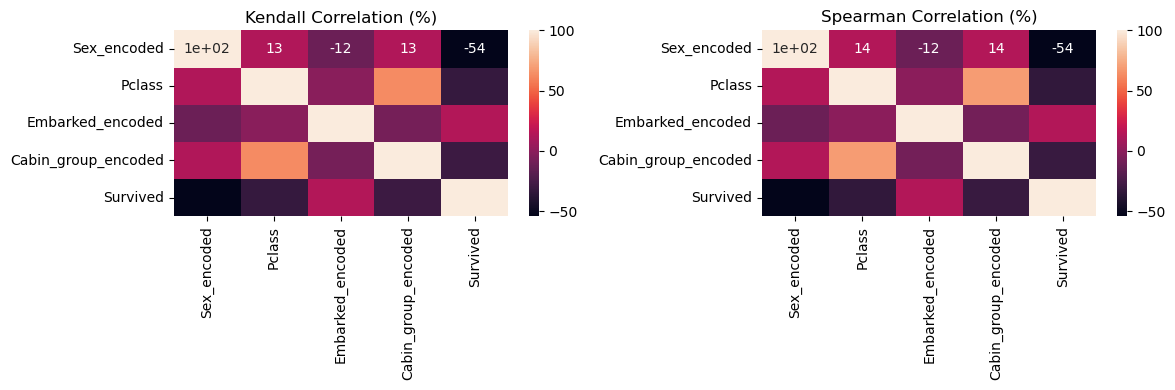

In [146]:
df_corr_kendall = df[CAT_CAT_ENCODED].corr(method='kendall') * 100 # rank based 
df_corr_spearman = df[CAT_CAT_ENCODED].corr(method='spearman') * 100 # non parametric

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(df_corr_kendall, annot=True, ax=axes[0])
axes[0].set_title("Kendall Correlation (%)")

sns.heatmap(df_corr_spearman, annot=True, ax=axes[1])
axes[1].set_title("Spearman Correlation (%)")

plt.tight_layout()
plt.show()

In [144]:
df_corr_kendall.style.applymap(highlight_scores, subset=CAT_CAT_ENCODED)

,Sex_encoded,Pclass,Embarked_encoded,Cabin_group_encoded,Survived
Sex_encoded,100.000000,12.932503,-11.705560,13.035728,-54.335138
Pclass,12.932503,100.000000,-0.890236,63.172670,-32.353318
Embarked_encoded,-11.705560,-0.890236,100.000000,-8.003278,13.208687
Cabin_group_encoded,13.035728,63.172670,-8.003278,100.000000,-29.975115
Survived,-54.335138,-32.353318,13.208687,-29.975115,100.000000


In [145]:
df_corr_spearman.style.applymap(highlight_scores, subset=CAT_CAT_ENCODED)

,Sex_encoded,Pclass,Embarked_encoded,Cabin_group_encoded,Survived
Sex_encoded,100.000000,13.577453,-12.039990,13.643760,-54.335138
Pclass,13.577453,100.000000,-0.496207,68.888984,-33.966794
Embarked_encoded,-12.039990,-0.496207,100.000000,-8.529733,13.586063
Cabin_group_encoded,13.643760,68.888984,-8.529733,100.000000,-31.373261
Survived,-54.335138,-33.966794,13.586063,-31.373261,100.000000


- Sex vs Survived
- Pclass vs Survived
- Cabin_group vs Survived
- Cabin_group vs Pclass - `inter-correlation`

#### 1. Sex vs Survived

In [66]:
df["Survived"].value_counts(normalize=True)*100

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

In [67]:
pd.crosstab(df["Sex"], df["Survived"], normalize=True) * 100

Survived,0,1
Sex,,
female,9.090909,26.150393
male,52.525253,12.233446


- being a `male` survival chance decreases that data shows
- let's check is it, by chance(some randomness) or we can count it as significant pattern 

##### Is there any relation between `sex` & `survived` ?

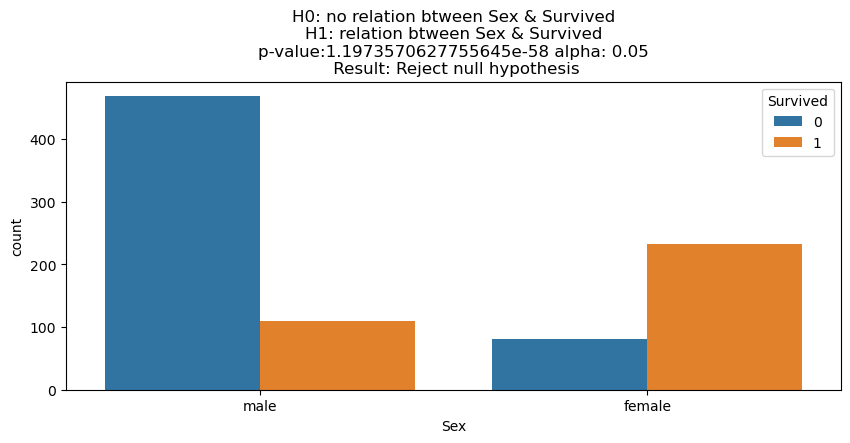

In [66]:
# sex vs survived
plot_bivariate(df, "Sex", "Survived")

**conclusion:**
- Yes, gender can affect the survival of passenger

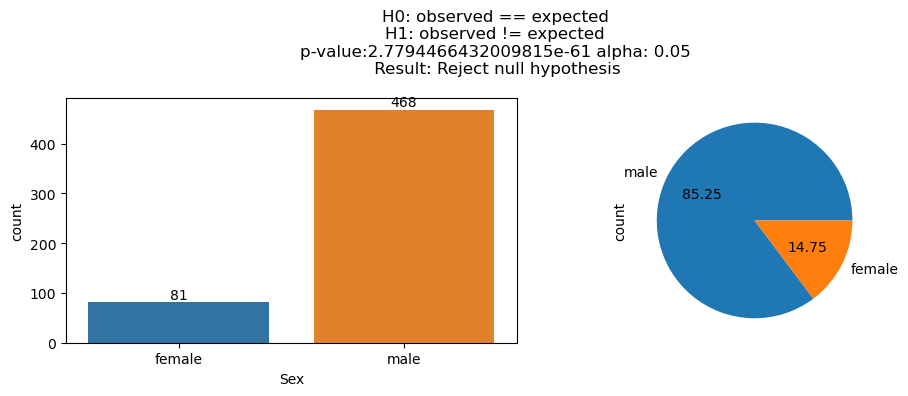

In [67]:
# not survived passengers
plot_cat_chart(df[df["Survived"] == 0], "Sex")

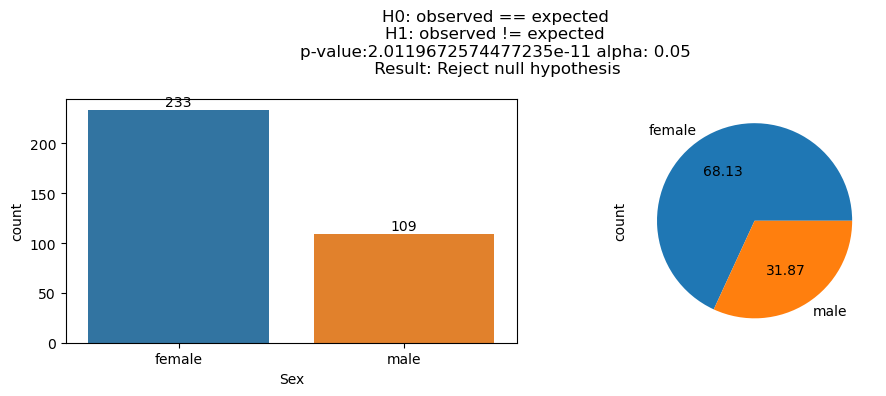

In [92]:
plot_cat_chart(df[df["Survived"] == 1], "Sex")

**conclusions:**
- there is relation between sex and survival of passengers
- there will be difference in sex ratios w.r.t survival of passengers 
- cross tables shows, 
    - if gender is male -> less survival chances as compare to female

    - if gender is female -> more survival chances as compare to male

#### 2. Pclass vs Survived

In [68]:
df["Survived"].value_counts(normalize=True)*100

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

In [69]:
pd.crosstab(df["Pclass"], df["Survived"], normalize=True) * 100

Survived,0,1
Pclass,,
1,8.978676,15.263749
2,10.886644,9.764310
3,41.750842,13.355780


##### Is there any relation between `Pclass` & `survived` ?

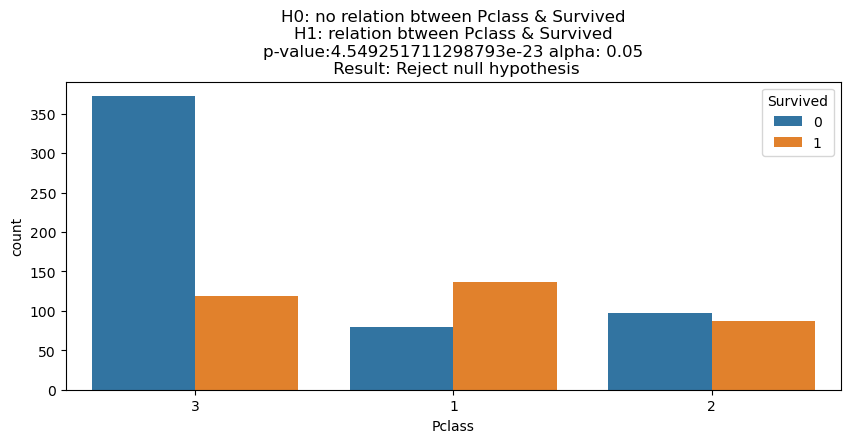

In [70]:

plot_bivariate(df, "Pclass", "Survived")

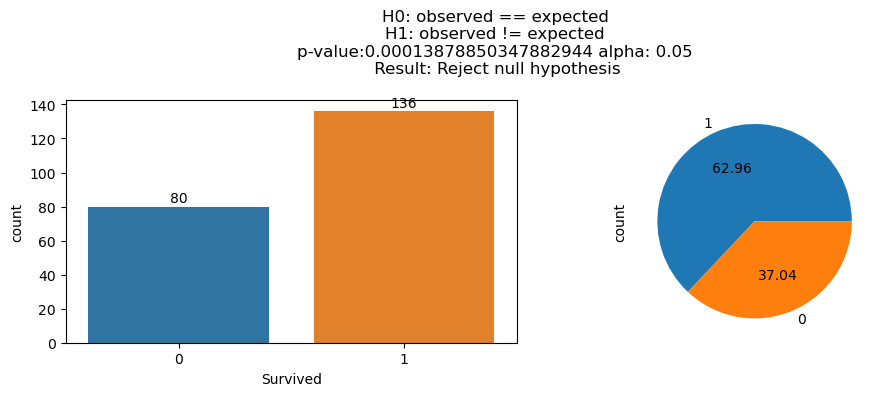

In [73]:
# class 1
plot_cat_chart(df[df["Pclass"] == 1], "Survived")

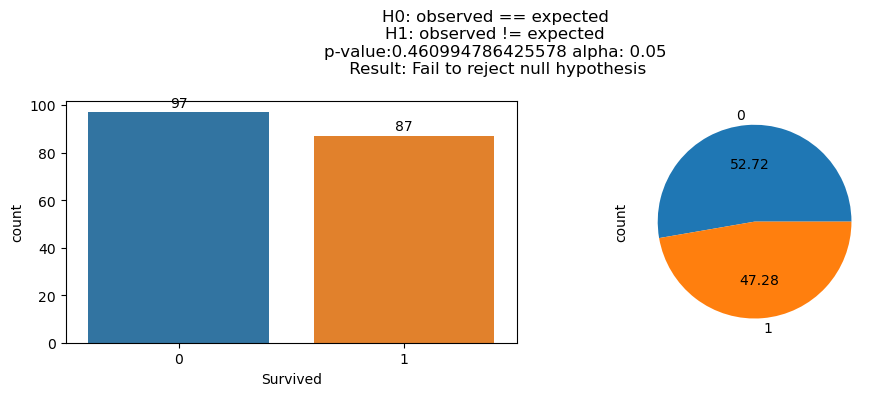

In [72]:
# class 2
plot_cat_chart(df[df["Pclass"] == 2], "Survived")

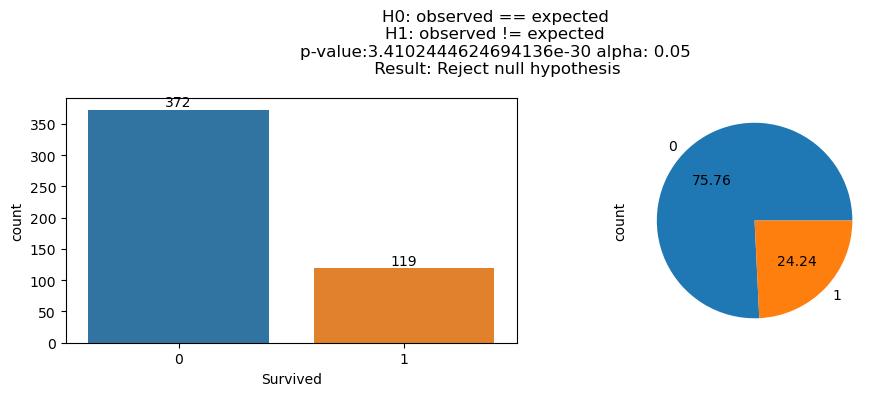

In [74]:
# class 3
plot_cat_chart(df[df["Pclass"] == 3], "Survived")

**conclusions:**
- there is relation between Pclass and survival of passengers
- there will be difference in class 1 and class 3 ratios w.r.t survival of passengers
- no signoficant difference in survival of passenger w.r.t to class 2 
- cross tables shows, 
    - if class is 1st -> high survival chances as compare to class 2 & 3

    - if class is 2nd -> less chance of survival as compare to 1st class

    - fi class is 3rd -> highly denger on survival of passenger

#### 3. Cabin Group vs Survived

In [75]:
df["Survived"].value_counts(normalize=True)*100

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

In [76]:
pd.crosstab(df["Cabin_group"], df["Survived"], normalize=True) * 100

Survived,0,1
Cabin_group,,
A,0.897868,0.785634
B,1.346801,3.928171
C,2.693603,3.928171
D,0.897868,2.805836
E,0.897868,2.693603
F,0.561167,0.897868
G,0.224467,0.224467
M,53.984287,23.120090
T,0.112233,0.000000


##### Is there any relation between `Cabin Group` & `survived` ?

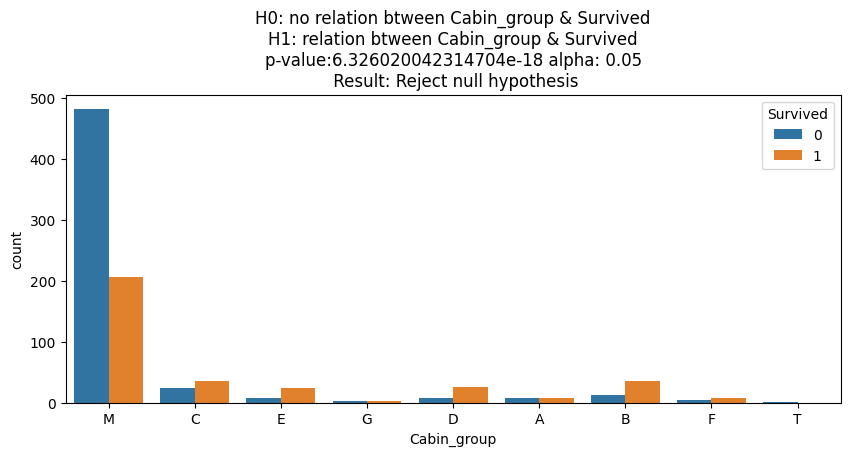

In [79]:
plot_bivariate(df, "Cabin_group", "Survived")

**conclusion:**
- Based on cabin in which passenger is present, survival is associated with it
- `M` is missing values , will treat those and come to final conclusion  


**Future Action:**

- Will treat cabin and flii it
- missing data might have gave wrong direction

#### 4. Cabin_group vs Pclass

In [77]:
df["Survived"].value_counts(normalize=True)*100

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

In [78]:
pd.crosstab(df["Cabin_group"], df["Pclass"], normalize=False)# * 100

Pclass,1,2,3
Cabin_group,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
M,40,168,479
T,1,0,0


##### Is there any relation between `Cabin Group` & `Pclass` ?

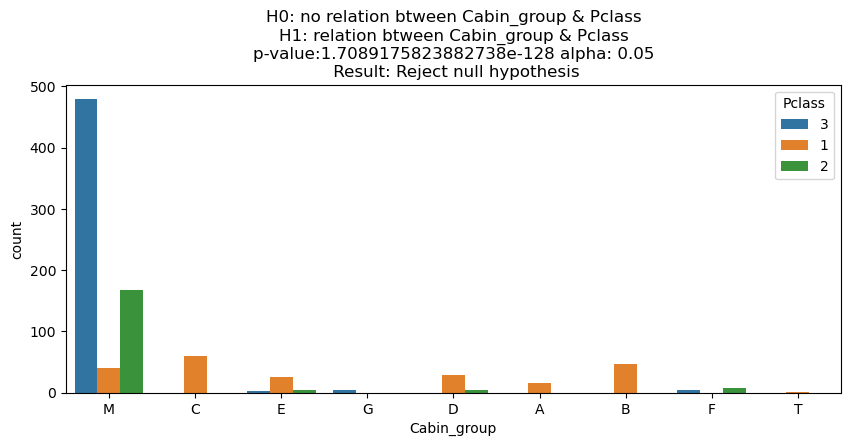

In [79]:
plot_bivariate(df, "Cabin_group", "Pclass")

**conclusion:**
- Based on cabin in which passenger is present, Pclass is associated with it
- `M` is missing values , will treat those and come to final conclusion  

### 3. Numerical - Categorical

In [80]:
# z-test - 2 category
def t_test_of_independence(df, x_col, y_col):
    """
    A t-test is a statistical test used to determine if there is a significant difference between 
    the means of two groups. It is commonly used when comparing the means of a numerical variable
    (dependent variable) across two categorical groups (independent variable).
    """
    h_0=f"H0: no differnce in mean's"
    h_1=f"H1: difference in mean's"
    categories = df[y_col].unique()
    # Separate numeric values by category
    group_A = df[df[y_col] == categories[0]][x_col]
    group_B = df[df[y_col] == categories[1]][x_col]

    # Perform independent t-test assuming equal variances
    t_stat, p_value = stats.ttest_ind(group_A, group_B)
    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

def plot_t_test_results(df, x_col, y_col):
    """
    this function is here to plot countplot and pie chart for binary categories
    """
    plt.figure(figsize=(10, 4))
    df_dict=t_test_of_independence(df, x_col, y_col)
    df_hypo_title = "{}\n{}\np-value:{} alpha: 0.05\n Result: {}".format(df_dict["h0"],
                                                                        df_dict["h1"],
                                                                        df_dict["p_val"],
                                                                        df_dict["cc"])
    plt.title(df_hypo_title)
    # print(type(subtotals))
    sns.boxplot(x=df[x_col], y=df[y_col])
    plt.show()

# Anova - > 2 category

In [81]:
def ANOVA(df, x_col, y_col):
    """
    A f-test is a statistical test used to determine if there is a significant difference between 
    the means of more than two groups. It is commonly used when comparing the means of a numerical variable
    (dependent variable) across more than two categorical groups (independent variable).
    """
    h_0=f"H0: no differnce in mean's"
    h_1=f"H1: difference in mean's"
    categories = df[y_col].unique()
    # Separate numeric values by category

    # Perform independent t-test assuming equal variances


    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}


- Age (float) - continuous
- Fare (integer) - continuous
- SibSp (ordinal) - discrete
- Parch (ordinal) - discrete

---

- Sex (nominal) - categorical
- Cabin (nominal) - categorical
- Embarked (nominal) - categorical
- Pclass (ordinal) - categorical
- Survived (nominal) - categorical


#### First will focus on Numeriec(X) and Categorical(Y)

#### Age - Survived

In [82]:
# Age vs Survived
df.groupby('Survived')['Age'].agg(['mean', 'std'])

,mean,std
Survived,,
0,30.028233,12.499986
1,28.291433,13.764425


##### Is there any difference in passenger's `Surivival` , based on mean `Age` ?

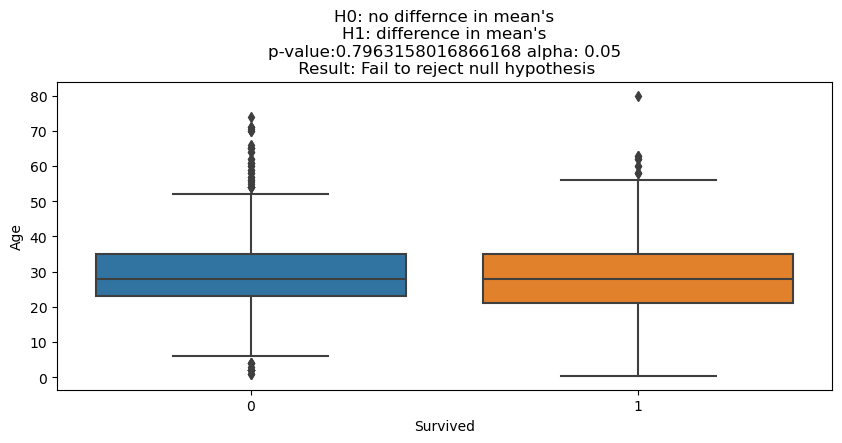

In [86]:
plot_t_test_results(df, "Survived", "Age")

**Conclusion:**
- age doesn't show any significant relation with survival
- though data have outliers, those might creating a bias

#### Fare - Survived

In [88]:
df.groupby('Survived')['Fare'].agg(['mean', 'std'])

,mean,std
Survived,,
0,22.117887,31.388207
1,48.395408,66.596998


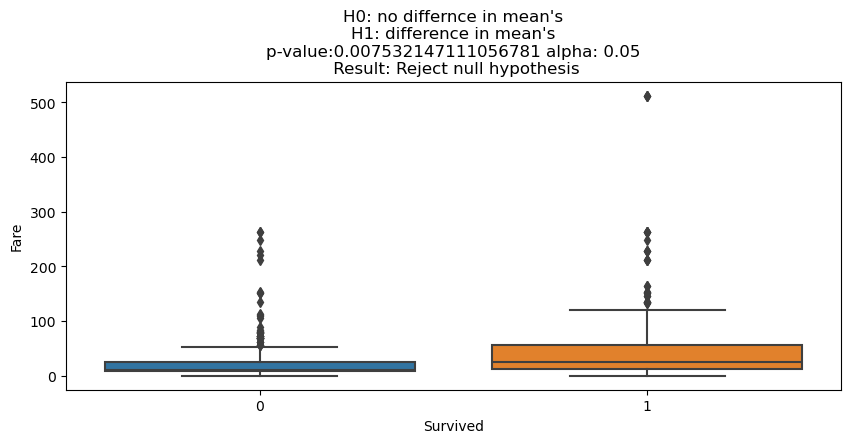

In [89]:
# Box plot
plot_t_test_results(df, "Survived", "Fare")

**Conclusion:**
- Fare shows significant relation with survival
- Costly ticket might save a passenger

#### SibSp - Survived

In [96]:
pd.crosstab(df["Survived"], df["SibSp"], normalize=True) * 100

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,44.668911,10.886644,1.683502,1.346801,1.683502,0.561167,0.785634
1,23.569024,12.570146,1.459035,0.448934,0.336700,0.000000,0.000000


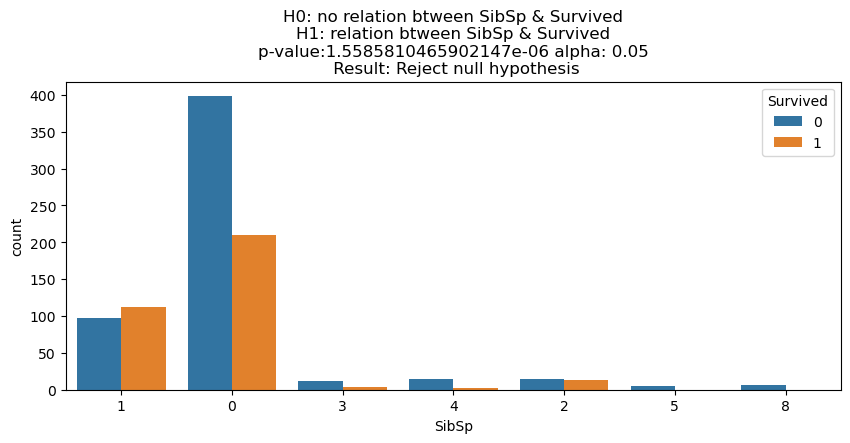

In [94]:
# perform chi square test
plot_bivariate(df, "SibSp", "Survived")

**conclusion:**
- Sibling or Spous presence can't help in survival
- though data shows, having one famliy member can increase chance of servival

#### Parch - Survived

In [97]:
pd.crosstab(df["Survived"], df["Parch"], normalize=True) * 100

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,49.943883,5.948373,4.489338,0.224467,0.448934,0.448934,0.112233
1,26.150393,7.295174,4.489338,0.336700,0.000000,0.112233,0.000000


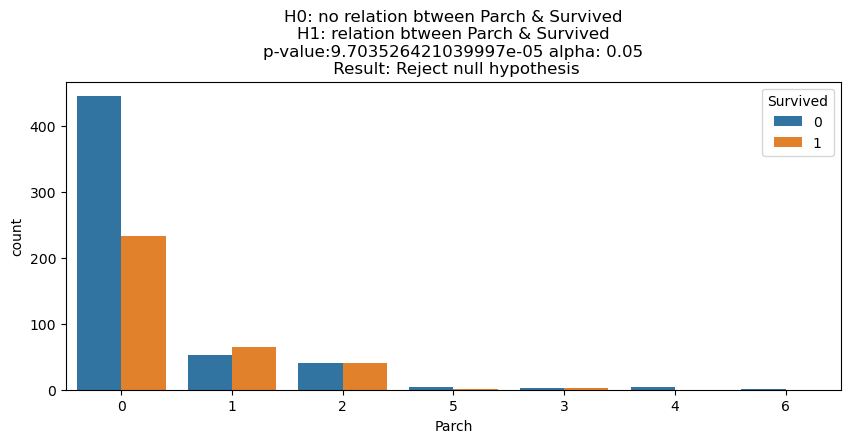

In [98]:
# perform chi square test
plot_bivariate(df, "Parch", "Survived")

**conclusion:**
- Parent or Child's presence can't help in survival
- though data shows, having one famliy member can increase chance of servival

#### Focus on Numeriec(X) and Categorical(X)

Numericals:
- Age (float) - continuous
- Fare (integer) - continuous
- SibSp (ordinal) - discrete
- Parch (ordinal) - discrete

---
Categoricals:
- Sex (nominal) - categorical
- Cabin (nominal) - categorical
- Embarked (nominal) - categorical
- Pclass (ordinal) - categorical
- Survived (nominal) - categorical (not includin)

---

1. Check based on 

- Sex - Age 
- Sex - Fare
- Sex - Family(SibSp + Parch)



#### Sex - Age

In [107]:
# Age vs Sex
df.groupby('Sex')['Age'].agg(['mean', 'std'])

,mean,std
Sex,,
female,27.929936,12.860189
male,30.140676,13.050847


##### Is there any difference in passenger's `Sex` , based on mean `Age` ?

In [108]:
df[['Sex', 'Sex_encoded']].head()

,Sex,Sex_encoded
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


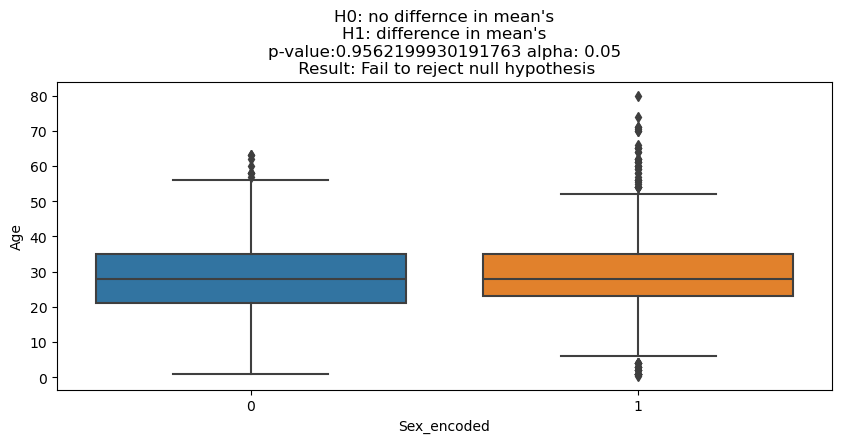

In [104]:
plot_t_test_results(df, "Sex_encoded", "Age")

**conclusion:**

- there difference im mean age of male and female
- females are quite younger as compare to males
- which might be decresing survival chances of males

#### Sex - Fare

In [109]:
# Sex vs Fare
df.groupby('Sex')['Fare'].agg(['mean', 'std'])

,mean,std
Sex,,
female,44.479818,57.997698
male,25.523893,43.138263


##### Is there any difference in passenger's `Sex` , based on mean `Fare` ?

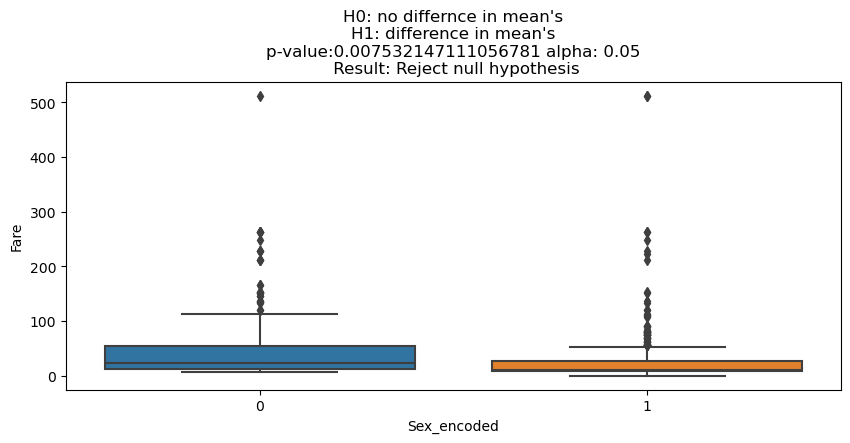

In [110]:
plot_t_test_results(df, "Sex_encoded", "Fare")

**conclusion:**

- there is difference in fare paid by male and female
- data shows females paid more then mens

#### Sex - Family(SibSp + Parch)

In [130]:
# passenger have family member with them or not
df["is_Family"] = df["Family_Member_Count"].apply(lambda x: 1 if x > 0 else 0)

In [133]:
# Sex vs is_Family
pd.crosstab(df["Sex"], df["is_Family"], normalize=True)

is_Family,0,1
Sex,,
female,0.141414,0.210999
male,0.461279,0.186308


##### Number of Siblings and Spouses are equally disributed in both genders`(Sex)` ?

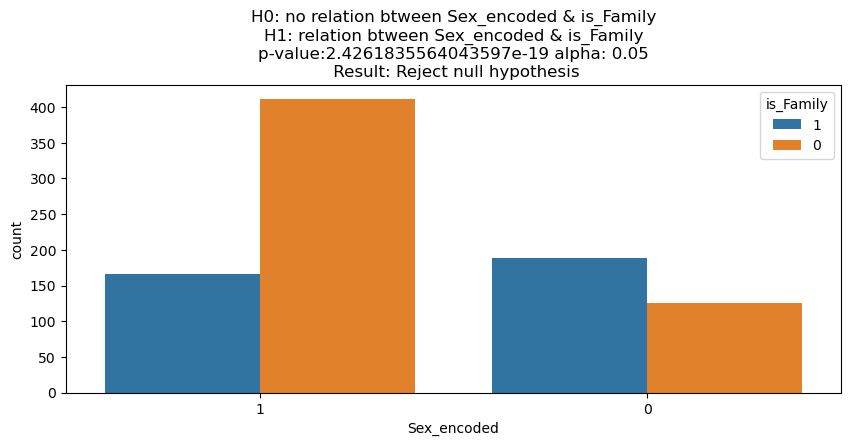

In [135]:
# perform chi square test
plot_bivariate(df, "Sex_encoded", "is_Family")

- there significant relation
- most of mens onboareded don't came with family memebers

2. Check based on 

- Pclass - Age 
- Pclass - Fare
- Pclass - Family(SibSp + Parch)


In [136]:
# Age vs Pclass
df.groupby('Pclass')['Age'].agg(['mean', 'std'])

,mean,std
Pclass,,
1,36.812130,14.182103
2,29.765380,13.581096
3,25.932627,10.697676


##### Is there any difference in passenger's `Pclass` , based on mean `Age` ?

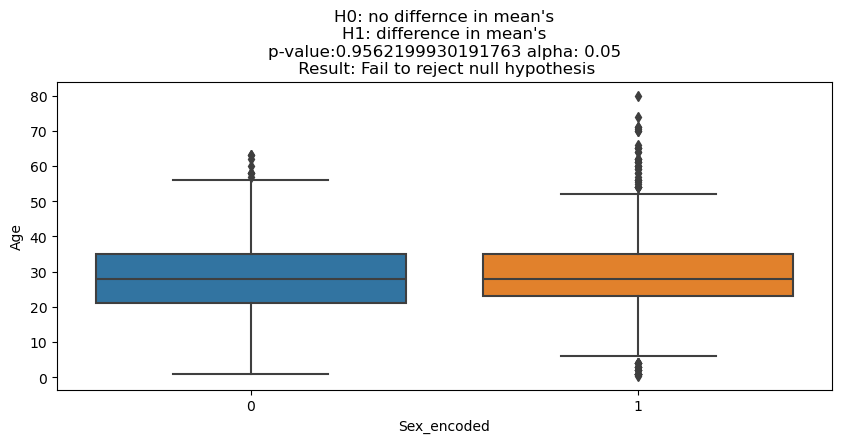

In [ ]:
# impliment anova
plot_t_test_results(df, "Sex_encoded", "Age")

**conclusion:**

- there difference im mean age of male and female
- females are quite younger as compare to males
- which might be decresing survival chances of males

#### Sex - Fare

In [ ]:
# Sex vs Fare
df.groupby('Sex')['Fare'].agg(['mean', 'std'])

,mean,std
Sex,,
female,44.479818,57.997698
male,25.523893,43.138263


##### Is there any difference in passenger's `Sex` , based on mean `Fare` ?

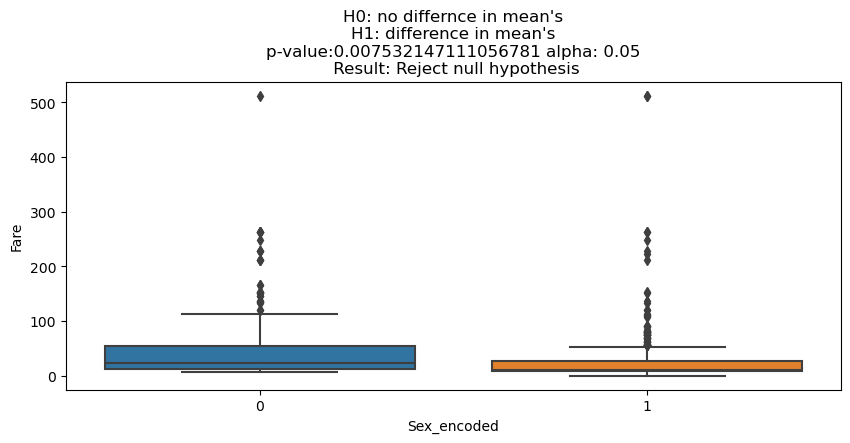

In [ ]:
plot_t_test_results(df, "Sex_encoded", "Fare")

**conclusion:**

- there is difference in fare paid by male and female
- data shows females paid more then mens

#### Sex - Family(SibSp + Parch)

In [ ]:
# passenger have family member with them or not
df["is_Family"] = df["Family_Member_Count"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Sex vs is_Family
pd.crosstab(df["Sex"], df["is_Family"], normalize=True)

is_Family,0,1
Sex,,
female,0.141414,0.210999
male,0.461279,0.186308


##### Number of Siblings and Spouses are equally disributed in both genders`(Sex)` ?

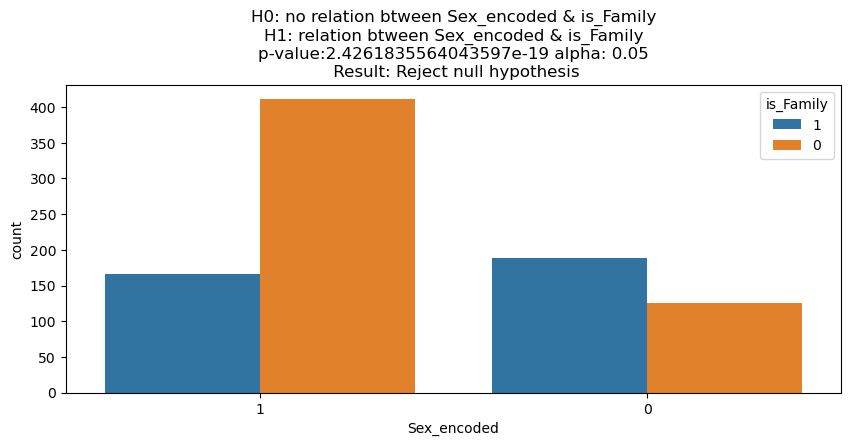

In [ ]:
# perform chi square test
plot_bivariate(df, "Sex_encoded", "is_Family")

- there significant relation
- most of mens onboareded don't came with family memebers

3. Check based on 

- Embarked - Age 
- Embarked - Fare
- Embarked - Family(SibSp + Parch)


## Multi-Variate Analysis

- Num-Num-Targte
- Num-Cat-Target
- Cat-Cat-Target

# Saving Version Used In Analysis

In [91]:
df.to_csv(os.path.join(DATA_DIR, "train_data_v1.csv"), index=False)